# Model Ensembling with Customized Neural Network

Name: Anthony Kevin Oktavius

In [1]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Library Import

In [3]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import json
import pickle


# import pytorch_lightning as pl
import imutils
import zipfile

from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.data import Dataset, BatchSampler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from torchvision.models.feature_extraction import create_feature_extractor
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from torchvision.ops import DropBlock2d
from google.colab import drive
from datetime import datetime
from operator import itemgetter
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import default_collate
from sklearn import metrics
from torch.optim.lr_scheduler import StepLR

Check if there is a GPU installed.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Print the specification of the device.

In [5]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10778957742119346486
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11900155286434309131
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [10]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
! unzip -qq alzheimers-dataset-4-class-of-images.zip

 91% 31.0M/34.1M [00:00<00:00, 138MB/s] 
100% 34.1M/34.1M [00:00<00:00, 111MB/s]


Set global variables

In [7]:
RANDOM_SEED = 42

## Data Preparation

In [11]:
def get_train_val_image_folder(image_folder, generator = None, test_size = 0.2):
  n_samples = len(image_folder)
  n_train_samples = int(n_samples * (1 - test_size))
  n_val_samples = int(n_samples * test_size) + 1
  train_image_folder, val_image_folder = torch.utils.data.random_split(
    image_folder, [n_train_samples, n_val_samples],
    generator = generator,
  )
  return train_image_folder, val_image_folder

def get_sorted_dictionary(my_dict, reverse = False):
  return dict(
      sorted(my_dict.items(), reverse = reverse)
  )

alzheimer_full_train_image_folders = torchvision.datasets.ImageFolder(
    "Alzheimer_s Dataset/train",
)

alzheimer_test_image_folders = torchvision.datasets.ImageFolder(
    "Alzheimer_s Dataset/test",
)

alzheimer_train_image_folders, alzheimer_val_image_folders = get_train_val_image_folder(
    alzheimer_full_train_image_folders,
)

print(f"Alzheimer train image folders datapoints: {len(alzheimer_train_image_folders)}")
print(f"Alzheimer val image folders datapoints: {len(alzheimer_val_image_folders)}")
print(alzheimer_test_image_folders)

number_of_samples_per_classes = defaultdict(int)
for _, class_index in alzheimer_train_image_folders:
  number_of_samples_per_classes[class_index] += 1

number_of_samples_per_classes = get_sorted_dictionary(number_of_samples_per_classes)
print(number_of_samples_per_classes)

Alzheimer train image folders datapoints: 4096
Alzheimer val image folders datapoints: 1025
Dataset ImageFolder
    Number of datapoints: 1279
    Root location: Alzheimer_s Dataset/test
{0: 581, 1: 42, 2: 2054, 3: 1419}


In [12]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((176, 176)),
    # v2.RandomResizedCrop((176, 176), scale = (0.1, 1), ratio = (1, 1)),
    # transforms.RandomAdjustSharpness(sharpness_factor = 20, p = 1),
    transforms.RandomHorizontalFlip(p = 0.5),
    # transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((176, 176)),
    # transforms.RandomAdjustSharpness(sharpness_factor = 10, p = 1),
    transforms.ToTensor(),
])

In [13]:
class AlzheimerDiseaseDataset(Dataset):
  def __init__(self, image_folders, transform = None):
    super(AlzheimerDiseaseDataset, self).__init__()
    self.image_folders = image_folders
    self.transform = transform

  def __getitem__(self, item_index):
    image, class_index = self.image_folders[item_index]
    # image = np.array(image).astype(np.float64)

    class_index = torch.tensor(class_index)

    if self.transform is not None:
      image = self.transform(image)

    return image, class_index

  def __len__(self):
    return len(self.image_folders)

alzheimer_disease_train_dataset = AlzheimerDiseaseDataset(
  alzheimer_train_image_folders,
  transform = transform,
)

alzheimer_disease_val_dataset = AlzheimerDiseaseDataset(
  alzheimer_val_image_folders,
  transform = val_test_transform,
)

alzheimer_disease_test_dataset = AlzheimerDiseaseDataset(
  alzheimer_test_image_folders,
  transform = val_test_transform,
)

In [14]:
def collate_fn(batch):
  # alpha = random.uniform(0, 0.5)
  cutmix = v2.CutMix(num_classes = 4, alpha = 0.5)
  batch = cutmix(*default_collate(batch))
  # print(batch)
  return batch

# Assign the weight manually
sampler_weights = []

for class_index in number_of_samples_per_classes:
  number_of_samples = number_of_samples_per_classes[class_index]
  weight = 1 / number_of_samples
  print(f"Class index weight of class {class_index}: {weight}, num samples: {number_of_samples}")
  sampler_weights += ([weight] * number_of_samples)

weighted_random_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    sampler_weights,
    len(sampler_weights),
    generator = torch.Generator().manual_seed(RANDOM_SEED),
)

batch_sampler = BatchSampler(
    weighted_random_sampler,
    batch_size = 16,
    drop_last = False,
)

alzheimer_train_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_train_dataset,
  collate_fn = collate_fn,
  batch_sampler = batch_sampler,
)

alzheimer_baseline_train_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_train_dataset,
)

alzheimer_val_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_val_dataset,
  batch_size = 16,
  shuffle = False,
)

alzheimer_test_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_test_dataset,
  batch_size = 16,
  shuffle = False
)

Class index weight of class 0: 0.0017211703958691911, num samples: 581
Class index weight of class 1: 0.023809523809523808, num samples: 42
Class index weight of class 2: 0.0004868549172346641, num samples: 2054
Class index weight of class 3: 0.0007047216349541931, num samples: 1419


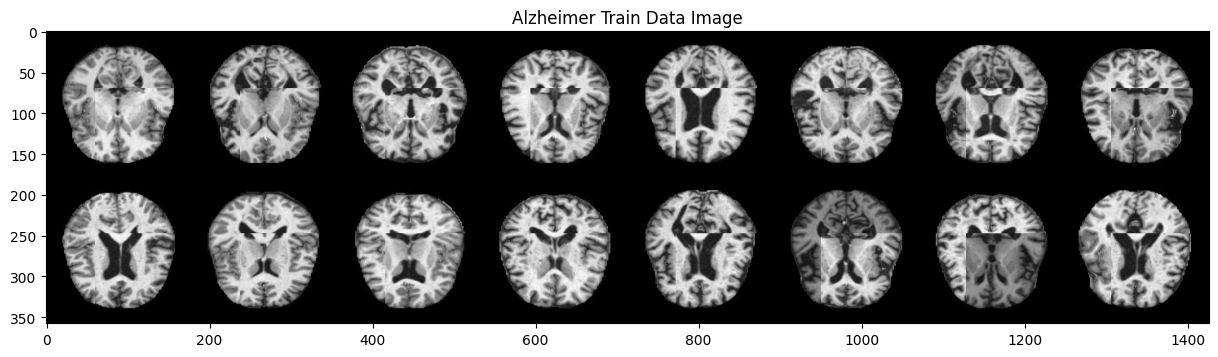

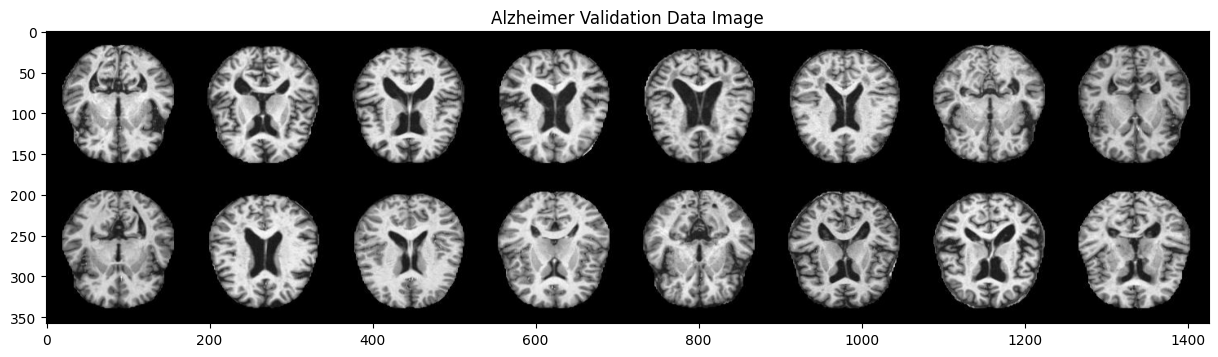

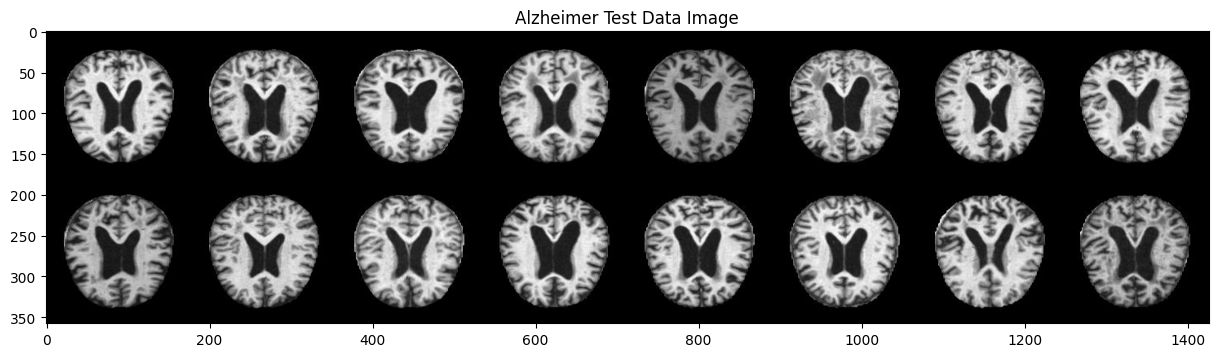

In [15]:
def visualize_pytorch_grid(images_in_batch, title):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.title(title)
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  images_in_batch,  _ = next(iter_loader)

  visualize_pytorch_grid(images_in_batch, title)

visualize_dataloader(alzheimer_train_data_loader, "Alzheimer Train Data Image")
visualize_dataloader(alzheimer_val_data_loader, "Alzheimer Validation Data Image")
visualize_dataloader(alzheimer_test_data_loader, "Alzheimer Test Data Image")

## Building Custom Model

In [19]:
class AlzheimerDiseaseModel(nn.Module):
  def __init__(self, n_classes):
    super(AlzheimerDiseaseModel, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        # nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2)
    )

    # self.drop_block_1 = DropBlock2d(p = 0.9, block_size = 39)
    self.dropout = nn.Dropout(p = 0.6)

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        # nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )

    # self.drop_block_2 = DropBlock2d(p = 0.9, block_size = 5)

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        # nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(128),
        # nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2)
    )

    self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p = 0.5),
        nn.ReLU(),
        nn.Linear(61952, 256),
        nn.ReLU(),
    )
    self.fc2 = nn.Sequential(nn.Linear(256, n_classes))

  def forward(self, x):
    x = self.conv1(x)
    # x = self.drop_block_1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    # x = self.drop_block_2(x)
    x = self.conv3(x)
    # x = self.conv4(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

alzheimer_disease_model = AlzheimerDiseaseModel(
    n_classes = 4
).to(device)

Visualize feature extraction information from the model layer, with a sample data.

In [20]:
def visualize_conv_weights(filters):
  number_of_filters = filters.shape[0]

  number_of_rows = math.ceil(number_of_filters / 32)
  number_of_columns = 32

  plt.figure(figsize = (80, number_of_rows * 2))
  border_in_string = "=" * 260
  plt.suptitle(f"{border_in_string}Convolutional Filters Visualization: {filters.shape}{border_in_string}")
  for index, filter in enumerate(filters):
    filter_weight = torch.sum(filter, dim = 0)

    plt.subplot(number_of_rows, number_of_columns, index + 1, label = f"Filter {index}")
    plt.imshow(filter_weight.cpu(), cmap = "gray")

  plt.tight_layout()
  plt.show()

def debug_model_weights(model_weights):
  print("Model Weights:")
  model_weight_keys = list(model_weights.keys())

  for weight_name in model_weights:
    print(f"{weight_name}: {model_weights[weight_name].shape}")

debug_model_weights(alzheimer_disease_model.state_dict())

Model Weights:
conv1.0.weight: torch.Size([32, 1, 3, 3])
conv1.0.bias: torch.Size([32])
conv1.2.weight: torch.Size([32])
conv1.2.bias: torch.Size([32])
conv1.2.running_mean: torch.Size([32])
conv1.2.running_var: torch.Size([32])
conv1.2.num_batches_tracked: torch.Size([])
conv1.3.weight: torch.Size([32, 32, 3, 3])
conv1.3.bias: torch.Size([32])
conv1.5.weight: torch.Size([32])
conv1.5.bias: torch.Size([32])
conv1.5.running_mean: torch.Size([32])
conv1.5.running_var: torch.Size([32])
conv1.5.num_batches_tracked: torch.Size([])
conv2.0.weight: torch.Size([64, 32, 3, 3])
conv2.0.bias: torch.Size([64])
conv2.2.weight: torch.Size([64])
conv2.2.bias: torch.Size([64])
conv2.2.running_mean: torch.Size([64])
conv2.2.running_var: torch.Size([64])
conv2.2.num_batches_tracked: torch.Size([])
conv2.3.weight: torch.Size([64, 64, 3, 3])
conv2.3.bias: torch.Size([64])
conv2.5.weight: torch.Size([64])
conv2.5.bias: torch.Size([64])
conv2.5.running_mean: torch.Size([64])
conv2.5.running_var: torch.Size(

In [21]:
def forward_propagate_layers(sample_datum, flattened_model_layers, device):
  all_layers_output = []
  with torch.no_grad():
    output = sample_datum
    for layer in flattened_model_layers:
      output = output.to(device)
      output = layer(output)
      all_layers_output.append(output)
      print(f"Layer: {layer}, with output size: {output.shape}")
  return all_layers_output

def flatten_layers_from_model(model):
  # Get all the model layers, except Sequential Layer,
  # since we'd like to iterate the layers one by one.
  model_layers = list(model.modules())[1:]
  flattened_model_layers = []

  # Filter layers, as we don't want to process sequential layers.
  for index, module in enumerate(model_layers):
    if type(module) != torch.nn.modules.container.Sequential:
      flattened_model_layers.append(module)

  return flattened_model_layers

def get_one_sample_data(tensor_dataset, data_index):
  sample_datum = tensor_dataset[data_index][0]
  print(f"Your previous sample data: {sample_datum.shape}")
  sample_datum = sample_datum.unsqueeze(0)
  print(f"Your current sample data after unsqueezed: {sample_datum.shape}")
  return sample_datum

sample_datum = get_one_sample_data(alzheimer_disease_train_dataset, 0)

model_flattened_layers = flatten_layers_from_model(alzheimer_disease_model)
model_all_layer_outputs = forward_propagate_layers(sample_datum, model_flattened_layers, device)

MAX_CONV_LAYERS = 9
model_conv_layers = model_flattened_layers[:MAX_CONV_LAYERS]
model_conv_layer_outputs = model_all_layer_outputs[:MAX_CONV_LAYERS] # Get only convolution layers output.

for layer_name, layer_output in zip(model_conv_layers, model_conv_layer_outputs):
  layer_output = torch.sum(layer_output, dim = 0)
  layer_name = str(layer_name).split("(")[0]

Your previous sample data: torch.Size([1, 176, 176])
Your current sample data after unsqueezed: torch.Size([1, 1, 176, 176])
Layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 176, 176])
Layer: ReLU(), with output size: torch.Size([1, 32, 176, 176])
Layer: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), with output size: torch.Size([1, 32, 176, 176])
Layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 176, 176])
Layer: ReLU(), with output size: torch.Size([1, 32, 176, 176])
Layer: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), with output size: torch.Size([1, 32, 176, 176])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 32, 88, 88])
Layer: Dropout(p=0.6, inplace=False), with output size: torch.Size([1, 32, 88, 88])
Layer: Conv2d(32, 64,

Get the number of parameters in the model.

In [22]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total model parameters: {count_parameters(alzheimer_disease_model)}")

Total model parameters: 16000484


Model Saving and Loading

In [23]:
BASE_SAVE_PATH = "drive/MyDrive/Models/Alzheimer_Disease"
COMMENT = "MultiConv_Dropout_Batch_Size_16_first_layer_42_second_layer_7_BatchNorm_LayerNorm_RandomHorizontalFlip_StepLR"
DATE = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
MODEL_NAME = f"Custom_Model_{DATE}_{COMMENT}"

print("Model will be saved and loaded with this name:")
print(MODEL_NAME)

Model will be saved and loaded with this name:
Custom_Model_2024_01_14_07_19_25_MultiConv_Dropout_Batch_Size_16_first_layer_42_second_layer_7_BatchNorm_LayerNorm_RandomHorizontalFlip_StepLR


In [34]:
def evaluate_model(model, dataloader, loss):
  with torch.no_grad():
    losses = []
    tk = tqdm(dataloader, total = len(dataloader))
    model.eval()
    for test_iteration, (images, labels) in enumerate(tk):
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)

      losses.append(loss)

    return losses

# For Reproducibility.
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

n_epochs = 300

alzheimer_disease_model = AlzheimerDiseaseModel(
    n_classes = 4
).to(device)

class_weights = torch.tensor([2.5, 4.0, 1.0, 1.5]).to(device)
loss_function = nn.CrossEntropyLoss(class_weights).to(device)

optimizer = optim.SGD(
  alzheimer_disease_model.parameters(), lr = 0.001, momentum = 0.1
)

# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

best_val_loss = float('inf')
best_test_loss = float('inf')

for current_epoch in range(n_epochs):
  train_tk = tqdm(alzheimer_train_data_loader, total = len(alzheimer_train_data_loader))
  alzheimer_disease_model.train()
  train_losses = []

  for train_iteration, (images, labels) in enumerate(train_tk):
    images = images.to(device)
    labels = labels.type(torch.DoubleTensor).to(device)

    optimizer.zero_grad()
    outputs = alzheimer_disease_model(images)

    loss = loss_function(outputs, labels)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

  avg_train_loss = sum(train_losses) / len(train_losses)
  print(f"Train loss ({current_epoch}): {avg_train_loss}")

  val_losses = evaluate_model(
      alzheimer_disease_model, alzheimer_val_data_loader, loss_function
  )

  test_losses = evaluate_model(
      alzheimer_disease_model, alzheimer_test_data_loader, loss_function
  )

  avg_val_loss = sum(val_losses) / len(val_losses)
  avg_test_loss = sum(test_losses) / len(test_losses)

  if best_val_loss > avg_val_loss and best_test_loss > avg_test_loss:
    print("NOTE: Reached the best validation and test loss. The best model has been saved!")
    torch.save(alzheimer_disease_model.state_dict(), f"{BASE_SAVE_PATH}/{MODEL_NAME}.pt")
    best_val_loss = avg_val_loss
    best_test_loss = avg_test_loss

  print(f"Validation Loss {current_epoch}: {avg_val_loss}, Test Loss: {avg_test_loss}")

  # scheduler.step()

100%|██████████| 256/256 [00:14<00:00, 17.88it/s]


Train loss (0): 1.5861684081871232


100%|██████████| 80/80 [00:02<00:00, 36.12it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 0: 1.0772093534469604, Test Loss: 1.0009279251098633


100%|██████████| 256/256 [00:15<00:00, 16.42it/s]


Train loss (1): 1.4542772863035116


100%|██████████| 80/80 [00:01<00:00, 68.19it/s]


Validation Loss 1: 1.2333184480667114, Test Loss: 1.0622094869613647


100%|██████████| 256/256 [00:11<00:00, 21.88it/s]


Train loss (2): 1.4575933624875794


100%|██████████| 80/80 [00:01<00:00, 71.79it/s]


Validation Loss 2: 1.2506588697433472, Test Loss: 1.0938721895217896


100%|██████████| 256/256 [00:11<00:00, 21.88it/s]


Train loss (3): 1.4082117351418793


100%|██████████| 80/80 [00:01<00:00, 72.23it/s]


Validation Loss 3: 1.6485979557037354, Test Loss: 1.4412481784820557


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (4): 1.3654117510088706


100%|██████████| 80/80 [00:01<00:00, 72.00it/s]


Validation Loss 4: 1.5369303226470947, Test Loss: 1.3763985633850098


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (5): 1.3330481296036731


100%|██████████| 80/80 [00:01<00:00, 72.51it/s]


Validation Loss 5: 1.6166749000549316, Test Loss: 1.4770158529281616


100%|██████████| 256/256 [00:11<00:00, 22.02it/s]


Train loss (6): 1.304740836410221


100%|██████████| 80/80 [00:01<00:00, 54.74it/s]


Validation Loss 6: 1.471560001373291, Test Loss: 1.2915167808532715


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (7): 1.2732703897526207


100%|██████████| 80/80 [00:01<00:00, 53.36it/s]


Validation Loss 7: 1.546781063079834, Test Loss: 1.4369248151779175


100%|██████████| 256/256 [00:11<00:00, 21.43it/s]


Train loss (8): 1.2909231876816718


100%|██████████| 80/80 [00:01<00:00, 54.92it/s]


Validation Loss 8: 1.7321045398712158, Test Loss: 1.5954420566558838


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (9): 1.2568442657754684


100%|██████████| 80/80 [00:01<00:00, 51.06it/s]


Validation Loss 9: 1.7793282270431519, Test Loss: 1.6520805358886719


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (10): 1.2464387255926028


100%|██████████| 80/80 [00:01<00:00, 49.04it/s]


Validation Loss 10: 2.251615047454834, Test Loss: 2.0613505840301514


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (11): 1.191193888438836


100%|██████████| 80/80 [00:01<00:00, 45.99it/s]


Validation Loss 11: 1.5781210660934448, Test Loss: 1.6216102838516235


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (12): 1.2151303937726257


100%|██████████| 80/80 [00:01<00:00, 48.58it/s]


Validation Loss 12: 1.486478567123413, Test Loss: 1.4640597105026245


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (13): 1.1669908123390307


100%|██████████| 80/80 [00:01<00:00, 43.58it/s]


Validation Loss 13: 1.0364097356796265, Test Loss: 1.063636302947998


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (14): 1.161427415299556


100%|██████████| 80/80 [00:01<00:00, 48.70it/s]


Validation Loss 14: 1.1592143774032593, Test Loss: 1.3567438125610352


100%|██████████| 256/256 [00:12<00:00, 20.61it/s]


Train loss (15): 1.1432855899409005


100%|██████████| 80/80 [00:01<00:00, 44.42it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 15: 0.7610383629798889, Test Loss: 0.9758260846138


100%|██████████| 256/256 [00:11<00:00, 21.89it/s]


Train loss (16): 1.0846952159377872


100%|██████████| 80/80 [00:01<00:00, 49.05it/s]


Validation Loss 16: 1.174278974533081, Test Loss: 1.3292356729507446


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (17): 1.1016717851954063


100%|██████████| 80/80 [00:01<00:00, 48.10it/s]


Validation Loss 17: 0.9699469804763794, Test Loss: 1.0504292249679565


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (18): 1.1000102578935156


100%|██████████| 80/80 [00:01<00:00, 47.82it/s]


Validation Loss 18: 1.1867702007293701, Test Loss: 1.1625359058380127


100%|██████████| 256/256 [00:11<00:00, 21.91it/s]


Train loss (19): 1.0997540454569688


100%|██████████| 80/80 [00:01<00:00, 48.99it/s]


Validation Loss 19: 1.0017919540405273, Test Loss: 1.0868638753890991


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (20): 1.0611936179572112


100%|██████████| 80/80 [00:01<00:00, 49.59it/s]


Validation Loss 20: 0.6690220236778259, Test Loss: 0.978550136089325


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (21): 1.0768506192523635


100%|██████████| 80/80 [00:01<00:00, 46.87it/s]


Validation Loss 21: 0.9103063344955444, Test Loss: 1.0942846536636353


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (22): 1.0644994866387307


100%|██████████| 80/80 [00:01<00:00, 43.30it/s]


Validation Loss 22: 0.9751107692718506, Test Loss: 1.0969690084457397


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (23): 1.0278224927040223


100%|██████████| 80/80 [00:01<00:00, 50.54it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 23: 0.6821691393852234, Test Loss: 0.9257265329360962


100%|██████████| 256/256 [00:11<00:00, 21.88it/s]


Train loss (24): 1.019573505826957


100%|██████████| 80/80 [00:01<00:00, 48.58it/s]


Validation Loss 24: 0.7746648788452148, Test Loss: 1.0499094724655151


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (25): 1.0218393608380913


100%|██████████| 80/80 [00:01<00:00, 49.55it/s]


Validation Loss 25: 0.8304646015167236, Test Loss: 1.0702940225601196


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (26): 1.0616062760068528


100%|██████████| 80/80 [00:01<00:00, 49.19it/s]


Validation Loss 26: 0.6333423852920532, Test Loss: 0.9285544753074646


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (27): 0.9848271939014287


100%|██████████| 80/80 [00:01<00:00, 51.11it/s]


Validation Loss 27: 0.764919638633728, Test Loss: 0.947644054889679


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (28): 1.0058779416197643


100%|██████████| 80/80 [00:01<00:00, 48.51it/s]


Validation Loss 28: 0.7260812520980835, Test Loss: 1.1161835193634033


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (29): 0.9567518518092156


100%|██████████| 80/80 [00:01<00:00, 49.51it/s]


Validation Loss 29: 0.6436320543289185, Test Loss: 1.0692182779312134


100%|██████████| 256/256 [00:11<00:00, 22.02it/s]


Train loss (30): 0.9832896065674953


100%|██████████| 80/80 [00:01<00:00, 53.54it/s]


Validation Loss 30: 0.5694968104362488, Test Loss: 0.9922661185264587


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (31): 0.9456357706093849


100%|██████████| 80/80 [00:01<00:00, 64.37it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 31: 0.6029642224311829, Test Loss: 0.886121392250061


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (32): 0.9338617830694149


100%|██████████| 80/80 [00:01<00:00, 72.06it/s]


Validation Loss 32: 0.5413010120391846, Test Loss: 0.887661874294281


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (33): 0.9249621732837409


100%|██████████| 80/80 [00:01<00:00, 70.46it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 33: 0.4602787494659424, Test Loss: 0.8253714442253113


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (34): 0.9399541548958454


100%|██████████| 80/80 [00:01<00:00, 72.14it/s]


Validation Loss 34: 0.6779205799102783, Test Loss: 1.0106755495071411


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (35): 0.9492593320294139


100%|██████████| 80/80 [00:01<00:00, 71.30it/s]


Validation Loss 35: 0.5332239866256714, Test Loss: 0.9088361859321594


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (36): 0.9202818119393041


100%|██████████| 80/80 [00:01<00:00, 72.12it/s]


Validation Loss 36: 0.5344811081886292, Test Loss: 0.8771823048591614


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (37): 0.8933229586023018


100%|██████████| 80/80 [00:01<00:00, 71.37it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 37: 0.4280249774456024, Test Loss: 0.8172532320022583


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (38): 0.869228294147694


100%|██████████| 80/80 [00:01<00:00, 70.91it/s]


Validation Loss 38: 0.523806631565094, Test Loss: 0.8726873397827148


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (39): 0.8855923657134416


100%|██████████| 80/80 [00:01<00:00, 70.59it/s]


Validation Loss 39: 0.4596201479434967, Test Loss: 0.8595075011253357


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (40): 0.9087545991358695


100%|██████████| 80/80 [00:01<00:00, 69.73it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 40: 0.39204227924346924, Test Loss: 0.7744407653808594


100%|██████████| 256/256 [00:11<00:00, 21.88it/s]


Train loss (41): 0.8544689943965941


100%|██████████| 80/80 [00:01<00:00, 73.27it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 41: 0.3545825779438019, Test Loss: 0.763198971748352


100%|██████████| 256/256 [00:11<00:00, 21.91it/s]


Train loss (42): 0.8782944466356781


100%|██████████| 80/80 [00:01<00:00, 71.08it/s]


Validation Loss 42: 0.3727506995201111, Test Loss: 0.7683190703392029


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (43): 0.8632856401093439


100%|██████████| 80/80 [00:01<00:00, 71.01it/s]


Validation Loss 43: 0.3744349181652069, Test Loss: 0.7326862215995789


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (44): 0.8568897904726152


100%|██████████| 80/80 [00:01<00:00, 60.79it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 44: 0.3236714005470276, Test Loss: 0.7465621829032898


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (45): 0.8599660735952727


100%|██████████| 80/80 [00:01<00:00, 57.03it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 45: 0.28492996096611023, Test Loss: 0.7031564712524414


100%|██████████| 256/256 [00:11<00:00, 21.87it/s]


Train loss (46): 0.8472427809870846


100%|██████████| 80/80 [00:01<00:00, 57.40it/s]


Validation Loss 46: 0.2890944480895996, Test Loss: 0.7395022511482239


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (47): 0.8333356831824137


100%|██████████| 80/80 [00:01<00:00, 53.09it/s]


Validation Loss 47: 0.3193732500076294, Test Loss: 0.7984148263931274


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (48): 0.8658951817925664


100%|██████████| 80/80 [00:01<00:00, 50.38it/s]


Validation Loss 48: 0.2896432876586914, Test Loss: 0.6801380515098572


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (49): 0.8753919189352791


100%|██████████| 80/80 [00:01<00:00, 49.09it/s]


Validation Loss 49: 0.3617205321788788, Test Loss: 0.8583532571792603


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (50): 0.8863564026386139


100%|██████████| 80/80 [00:01<00:00, 49.29it/s]


Validation Loss 50: 0.3540323078632355, Test Loss: 0.7105910181999207


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (51): 0.8294802804931264


100%|██████████| 80/80 [00:01<00:00, 50.36it/s]


Validation Loss 51: 0.28516554832458496, Test Loss: 0.7509467005729675


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (52): 0.8254859262364301


100%|██████████| 80/80 [00:01<00:00, 47.72it/s]


Validation Loss 52: 0.3243025839328766, Test Loss: 0.7323815226554871


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (53): 0.8358023346299125


100%|██████████| 80/80 [00:01<00:00, 48.70it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 53: 0.25931552052497864, Test Loss: 0.6833581328392029


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (54): 0.8545938937285072


100%|██████████| 80/80 [00:01<00:00, 50.56it/s]


Validation Loss 54: 0.24147635698318481, Test Loss: 0.7132689356803894


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (55): 0.7953916415329136


100%|██████████| 80/80 [00:01<00:00, 47.36it/s]


Validation Loss 55: 0.2933030128479004, Test Loss: 0.7337293028831482


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (56): 0.830691029414616


100%|██████████| 80/80 [00:01<00:00, 50.08it/s]


Validation Loss 56: 0.28019869327545166, Test Loss: 0.69198077917099


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (57): 0.8217039179021572


100%|██████████| 80/80 [00:01<00:00, 50.38it/s]


Validation Loss 57: 0.26444011926651, Test Loss: 0.6733444929122925


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (58): 0.79390225235189


100%|██████████| 80/80 [00:01<00:00, 49.73it/s]


Validation Loss 58: 0.2920607030391693, Test Loss: 0.7718342542648315


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (59): 0.7893532944733158


100%|██████████| 80/80 [00:01<00:00, 50.13it/s]


Validation Loss 59: 0.2281273603439331, Test Loss: 0.7035009860992432


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (60): 0.8124527453110435


100%|██████████| 80/80 [00:01<00:00, 49.38it/s]


Validation Loss 60: 0.26215341687202454, Test Loss: 0.682284951210022


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (61): 0.83741511843214


100%|██████████| 80/80 [00:01<00:00, 50.43it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 61: 0.24184206128120422, Test Loss: 0.6776859760284424


100%|██████████| 256/256 [00:11<00:00, 21.90it/s]


Train loss (62): 0.8048023701127465


100%|██████████| 80/80 [00:01<00:00, 49.17it/s]


Validation Loss 62: 0.2433750480413437, Test Loss: 0.6946285963058472


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (63): 0.8191224329957629


100%|██████████| 80/80 [00:01<00:00, 50.45it/s]


Validation Loss 63: 0.21237893402576447, Test Loss: 0.6810031533241272


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (64): 0.7568249714992723


100%|██████████| 80/80 [00:01<00:00, 49.20it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 64: 0.20807866752147675, Test Loss: 0.663365364074707


100%|██████████| 256/256 [00:11<00:00, 21.89it/s]


Train loss (65): 0.809513683906005


100%|██████████| 80/80 [00:01<00:00, 50.76it/s]


Validation Loss 65: 0.25463932752609253, Test Loss: 0.7259179949760437


100%|██████████| 256/256 [00:13<00:00, 18.86it/s]


Train loss (66): 0.7625464422512889


100%|██████████| 80/80 [00:01<00:00, 68.04it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 66: 0.19647960364818573, Test Loss: 0.6530328392982483


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (67): 0.7583955558581141


100%|██████████| 80/80 [00:01<00:00, 62.96it/s]


Validation Loss 67: 0.22439952194690704, Test Loss: 0.6621108651161194


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (68): 0.7635328576155915


100%|██████████| 80/80 [00:01<00:00, 56.65it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 68: 0.19641391932964325, Test Loss: 0.6395224928855896


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (69): 0.7727963167796283


100%|██████████| 80/80 [00:01<00:00, 53.84it/s]


Validation Loss 69: 0.19590716063976288, Test Loss: 0.6758806109428406


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (70): 0.7219816372834912


100%|██████████| 80/80 [00:01<00:00, 51.94it/s]


Validation Loss 70: 0.2035028040409088, Test Loss: 0.6904157996177673


100%|██████████| 256/256 [00:11<00:00, 22.02it/s]


Train loss (71): 0.7982257565451247


100%|██████████| 80/80 [00:01<00:00, 50.05it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 71: 0.19099481403827667, Test Loss: 0.6337394714355469


100%|██████████| 256/256 [00:12<00:00, 20.97it/s]


Train loss (72): 0.7833257457159297


100%|██████████| 80/80 [00:01<00:00, 56.19it/s]


Validation Loss 72: 0.18809804320335388, Test Loss: 0.658650815486908


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (73): 0.7476521757584141


100%|██████████| 80/80 [00:01<00:00, 52.95it/s]


Validation Loss 73: 0.17742908000946045, Test Loss: 0.6424610018730164


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (74): 0.7685009071551743


100%|██████████| 80/80 [00:01<00:00, 52.41it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 74: 0.17201021313667297, Test Loss: 0.628032922744751


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (75): 0.7463510621496975


100%|██████████| 80/80 [00:01<00:00, 50.34it/s]


Validation Loss 75: 0.17367851734161377, Test Loss: 0.6250051856040955


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (76): 0.7386167356307292


100%|██████████| 80/80 [00:01<00:00, 47.70it/s]


Validation Loss 76: 0.17615433037281036, Test Loss: 0.6711264848709106


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (77): 0.7799107980157379


100%|██████████| 80/80 [00:01<00:00, 50.21it/s]


Validation Loss 77: 0.17684383690357208, Test Loss: 0.638631284236908


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (78): 0.7373396105503826


100%|██████████| 80/80 [00:01<00:00, 48.95it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 78: 0.16317927837371826, Test Loss: 0.6278414130210876


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (79): 0.7331182105966761


100%|██████████| 80/80 [00:01<00:00, 48.33it/s]


Validation Loss 79: 0.14132577180862427, Test Loss: 0.6361055374145508


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (80): 0.7753615976993808


100%|██████████| 80/80 [00:01<00:00, 47.20it/s]


Validation Loss 80: 0.1775539219379425, Test Loss: 0.6185429096221924


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (81): 0.7429187054167385


100%|██████████| 80/80 [00:01<00:00, 49.67it/s]


Validation Loss 81: 0.17280270159244537, Test Loss: 0.6828709840774536


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (82): 0.7603757052742236


100%|██████████| 80/80 [00:01<00:00, 47.95it/s]


Validation Loss 82: 0.16886357963085175, Test Loss: 0.6453518867492676


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (83): 0.7379962824763353


100%|██████████| 80/80 [00:01<00:00, 50.14it/s]


Validation Loss 83: 0.18197587132453918, Test Loss: 0.6055857539176941


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (84): 0.7570332416458038


100%|██████████| 80/80 [00:01<00:00, 48.16it/s]


Validation Loss 84: 0.18402442336082458, Test Loss: 0.6222825050354004


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (85): 0.7689485130244973


100%|██████████| 80/80 [00:01<00:00, 48.83it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 85: 0.15589213371276855, Test Loss: 0.603457510471344


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (86): 0.7178546628049056


100%|██████████| 80/80 [00:01<00:00, 49.76it/s]


Validation Loss 86: 0.16796192526817322, Test Loss: 0.6057491302490234


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (87): 0.7863162898523631


100%|██████████| 80/80 [00:01<00:00, 50.23it/s]


Validation Loss 87: 0.17093530297279358, Test Loss: 0.6305522322654724


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (88): 0.7433755030648386


100%|██████████| 80/80 [00:01<00:00, 49.41it/s]


Validation Loss 88: 0.1404106765985489, Test Loss: 0.6286022663116455


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (89): 0.7630569495719689


100%|██████████| 80/80 [00:01<00:00, 48.62it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 89: 0.1503310203552246, Test Loss: 0.6009790897369385


100%|██████████| 256/256 [00:11<00:00, 21.91it/s]


Train loss (90): 0.7238559574258733


100%|██████████| 80/80 [00:01<00:00, 50.62it/s]


Validation Loss 90: 0.16429294645786285, Test Loss: 0.6156940460205078


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (91): 0.7469315234804502


100%|██████████| 80/80 [00:01<00:00, 48.69it/s]


Validation Loss 91: 0.15704365074634552, Test Loss: 0.6364903450012207


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (92): 0.6893113441779588


100%|██████████| 80/80 [00:01<00:00, 50.78it/s]


Validation Loss 92: 0.14951783418655396, Test Loss: 0.6293154358863831


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (93): 0.7618838744769708


100%|██████████| 80/80 [00:01<00:00, 48.35it/s]


Validation Loss 93: 0.1571502536535263, Test Loss: 0.5931676030158997


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (94): 0.736653500652615


100%|██████████| 80/80 [00:01<00:00, 48.80it/s]


Validation Loss 94: 0.1359623521566391, Test Loss: 0.6127916574478149


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (95): 0.7001527519651854


100%|██████████| 80/80 [00:01<00:00, 48.89it/s]


Validation Loss 95: 0.13331730663776398, Test Loss: 0.6418107748031616


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (96): 0.6918641577336139


100%|██████████| 80/80 [00:01<00:00, 49.55it/s]


Validation Loss 96: 0.12418939173221588, Test Loss: 0.6279342770576477


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (97): 0.7142309629252183


100%|██████████| 80/80 [00:01<00:00, 46.09it/s]


Validation Loss 97: 0.13561251759529114, Test Loss: 0.6759950518608093


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (98): 0.7376120050403431


100%|██████████| 80/80 [00:01<00:00, 49.17it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 98: 0.12033711373806, Test Loss: 0.5868592262268066


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (99): 0.7417590584210093


100%|██████████| 80/80 [00:01<00:00, 50.93it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 99: 0.11502569168806076, Test Loss: 0.5829788446426392


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (100): 0.7693988664166144


100%|██████████| 80/80 [00:01<00:00, 50.41it/s]


Validation Loss 100: 0.12188015133142471, Test Loss: 0.6075506806373596


100%|██████████| 256/256 [00:11<00:00, 22.02it/s]


Train loss (101): 0.73082736345275


100%|██████████| 80/80 [00:01<00:00, 48.19it/s]


Validation Loss 101: 0.1151113212108612, Test Loss: 0.6085131764411926


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (102): 0.7297319881156148


100%|██████████| 80/80 [00:01<00:00, 48.01it/s]


Validation Loss 102: 0.14255577325820923, Test Loss: 0.6111389994621277


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (103): 0.710625132815334


100%|██████████| 80/80 [00:01<00:00, 50.32it/s]


Validation Loss 103: 0.11356698721647263, Test Loss: 0.6231697797775269


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (104): 0.6592089554776756


100%|██████████| 80/80 [00:01<00:00, 48.36it/s]


Validation Loss 104: 0.1277794986963272, Test Loss: 0.638573169708252


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (105): 0.6970315418371379


100%|██████████| 80/80 [00:01<00:00, 49.90it/s]


Validation Loss 105: 0.12771274149417877, Test Loss: 0.6161390542984009


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (106): 0.7408141884553376


100%|██████████| 80/80 [00:01<00:00, 51.75it/s]


Validation Loss 106: 0.11858212202787399, Test Loss: 0.5900208353996277


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (107): 0.7247157544390966


100%|██████████| 80/80 [00:01<00:00, 64.70it/s]


Validation Loss 107: 0.1204259917140007, Test Loss: 0.6405342221260071


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (108): 0.7065436763015945


100%|██████████| 80/80 [00:01<00:00, 70.67it/s]


Validation Loss 108: 0.1175960972905159, Test Loss: 0.5896613597869873


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (109): 0.6779615287322542


100%|██████████| 80/80 [00:01<00:00, 68.37it/s]


Validation Loss 109: 0.11842794716358185, Test Loss: 0.6034846305847168


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (110): 0.7121845064747478


100%|██████████| 80/80 [00:01<00:00, 70.30it/s]


Validation Loss 110: 0.11910548806190491, Test Loss: 0.5961625576019287


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (111): 0.7268616037023207


100%|██████████| 80/80 [00:01<00:00, 70.98it/s]


Validation Loss 111: 0.11094079911708832, Test Loss: 0.6192288398742676


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (112): 0.7339003141592277


100%|██████████| 80/80 [00:01<00:00, 71.29it/s]


Validation Loss 112: 0.11956701427698135, Test Loss: 0.5828335285186768


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (113): 0.6909696598525207


100%|██████████| 80/80 [00:01<00:00, 73.36it/s]


Validation Loss 113: 0.12436986714601517, Test Loss: 0.5834848284721375


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (114): 0.7397994783580039


100%|██████████| 80/80 [00:01<00:00, 70.81it/s]


Validation Loss 114: 0.11708595603704453, Test Loss: 0.5663089752197266


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (115): 0.7456741782847798


100%|██████████| 80/80 [00:01<00:00, 70.28it/s]


Validation Loss 115: 0.12155941128730774, Test Loss: 0.5765102505683899


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (116): 0.7005116256327928


100%|██████████| 80/80 [00:01<00:00, 70.86it/s]


Validation Loss 116: 0.11917191743850708, Test Loss: 0.5769914388656616


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (117): 0.7194070991239286


100%|██████████| 80/80 [00:01<00:00, 71.71it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 117: 0.0999399870634079, Test Loss: 0.5692063570022583


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (118): 0.7009976908788322


100%|██████████| 80/80 [00:01<00:00, 62.66it/s]


Validation Loss 118: 0.10676930844783783, Test Loss: 0.5778632164001465


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (119): 0.7126702381278389


100%|██████████| 80/80 [00:01<00:00, 54.96it/s]


Validation Loss 119: 0.10188250988721848, Test Loss: 0.5828585028648376


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (120): 0.710432525288967


100%|██████████| 80/80 [00:01<00:00, 48.87it/s]


Validation Loss 120: 0.10727928578853607, Test Loss: 0.6237154006958008


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (121): 0.6958732765024206


100%|██████████| 80/80 [00:01<00:00, 50.61it/s]


Validation Loss 121: 0.10438620299100876, Test Loss: 0.5987471342086792


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (122): 0.6781829903616905


100%|██████████| 80/80 [00:01<00:00, 49.63it/s]


Validation Loss 122: 0.09149656444787979, Test Loss: 0.5994848608970642


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (123): 0.7305595697375087


100%|██████████| 80/80 [00:01<00:00, 49.33it/s]


Validation Loss 123: 0.11392083764076233, Test Loss: 0.5935565829277039


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (124): 0.7087560724412321


100%|██████████| 80/80 [00:01<00:00, 48.45it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 124: 0.09814036637544632, Test Loss: 0.5673547983169556


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (125): 0.6606179070522786


100%|██████████| 80/80 [00:01<00:00, 50.39it/s]


Validation Loss 125: 0.1091245636343956, Test Loss: 0.578140914440155


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (126): 0.7164117584058838


100%|██████████| 80/80 [00:01<00:00, 47.99it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 126: 0.0934436097741127, Test Loss: 0.5578404664993286


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (127): 0.6901035175157699


100%|██████████| 80/80 [00:01<00:00, 48.08it/s]


Validation Loss 127: 0.10047841817140579, Test Loss: 0.5895406603813171


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (128): 0.6450261687441328


100%|██████████| 80/80 [00:01<00:00, 49.25it/s]


Validation Loss 128: 0.09810343384742737, Test Loss: 0.546566903591156


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (129): 0.7010291450861698


100%|██████████| 80/80 [00:01<00:00, 49.20it/s]


Validation Loss 129: 0.10235527902841568, Test Loss: 0.5530948042869568


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (130): 0.676549632045948


100%|██████████| 80/80 [00:01<00:00, 49.02it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 130: 0.0905923992395401, Test Loss: 0.5560473799705505


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (131): 0.6850882097291768


100%|██████████| 80/80 [00:01<00:00, 49.98it/s]


Validation Loss 131: 0.09496452659368515, Test Loss: 0.5653249621391296


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (132): 0.6792398155192746


100%|██████████| 80/80 [00:01<00:00, 49.80it/s]


Validation Loss 132: 0.09017153084278107, Test Loss: 0.5963164567947388


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (133): 0.6966532190672468


100%|██████████| 80/80 [00:01<00:00, 49.37it/s]


Validation Loss 133: 0.10502556711435318, Test Loss: 0.5671873092651367


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (134): 0.6829797768489223


100%|██████████| 80/80 [00:01<00:00, 49.28it/s]


Validation Loss 134: 0.09525466710329056, Test Loss: 0.6020509600639343


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (135): 0.6413303716490205


100%|██████████| 80/80 [00:01<00:00, 49.25it/s]


Validation Loss 135: 0.0845273956656456, Test Loss: 0.5592425465583801


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (136): 0.6825337256248215


100%|██████████| 80/80 [00:01<00:00, 49.42it/s]


Validation Loss 136: 0.08872886747121811, Test Loss: 0.5716863870620728


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (137): 0.6763072668799093


100%|██████████| 80/80 [00:01<00:00, 47.76it/s]


Validation Loss 137: 0.0955490693449974, Test Loss: 0.5846512913703918


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (138): 0.6752237158763599


100%|██████████| 80/80 [00:01<00:00, 49.51it/s]


Validation Loss 138: 0.10477804392576218, Test Loss: 0.6004398465156555


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (139): 0.7136553846134971


100%|██████████| 80/80 [00:01<00:00, 49.19it/s]


Validation Loss 139: 0.10342241078615189, Test Loss: 0.5731772184371948


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (140): 0.6881117068695776


100%|██████████| 80/80 [00:01<00:00, 55.14it/s]


Validation Loss 140: 0.10635458678007126, Test Loss: 0.5903500318527222


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (141): 0.6921815168611655


100%|██████████| 80/80 [00:01<00:00, 70.96it/s]


Validation Loss 141: 0.0780462697148323, Test Loss: 0.5621511340141296


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (142): 0.699683009195991


100%|██████████| 80/80 [00:01<00:00, 68.68it/s]


Validation Loss 142: 0.09380406886339188, Test Loss: 0.5654551982879639


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (143): 0.6720150908926239


100%|██████████| 80/80 [00:01<00:00, 68.35it/s]


Validation Loss 143: 0.09288356453180313, Test Loss: 0.573671281337738


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (144): 0.6591900117013323


100%|██████████| 80/80 [00:01<00:00, 68.78it/s]


Validation Loss 144: 0.08892624080181122, Test Loss: 0.5770139694213867


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (145): 0.6570775183823803


100%|██████████| 80/80 [00:01<00:00, 70.99it/s]


Validation Loss 145: 0.09447667002677917, Test Loss: 0.5767240524291992


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (146): 0.6947133054459798


100%|██████████| 80/80 [00:01<00:00, 71.79it/s]


Validation Loss 146: 0.0925874263048172, Test Loss: 0.58155357837677


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (147): 0.6642831651300776


100%|██████████| 80/80 [00:01<00:00, 70.94it/s]


Validation Loss 147: 0.111308254301548, Test Loss: 0.6320288181304932


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (148): 0.6806740744264599


100%|██████████| 80/80 [00:01<00:00, 67.96it/s]


Validation Loss 148: 0.08934225142002106, Test Loss: 0.5723254680633545


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (149): 0.6819861858762144


100%|██████████| 80/80 [00:01<00:00, 69.55it/s]


Validation Loss 149: 0.09366583079099655, Test Loss: 0.6008557081222534


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (150): 0.6451975743430409


100%|██████████| 80/80 [00:01<00:00, 64.42it/s]


Validation Loss 150: 0.08493438363075256, Test Loss: 0.5820584297180176


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (151): 0.650722251399499


100%|██████████| 80/80 [00:01<00:00, 54.89it/s]


Validation Loss 151: 0.08892668038606644, Test Loss: 0.5720316171646118


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (152): 0.6880698177595743


100%|██████████| 80/80 [00:01<00:00, 52.26it/s]


Validation Loss 152: 0.09709430485963821, Test Loss: 0.5967198610305786


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (153): 0.6681456967108382


100%|██████████| 80/80 [00:01<00:00, 44.08it/s]


Validation Loss 153: 0.08353504538536072, Test Loss: 0.5593745112419128


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (154): 0.691369243068873


100%|██████████| 80/80 [00:01<00:00, 56.06it/s]


Validation Loss 154: 0.09305813908576965, Test Loss: 0.565247654914856


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (155): 0.6765839805627456


100%|██████████| 80/80 [00:01<00:00, 52.52it/s]


Validation Loss 155: 0.09386452287435532, Test Loss: 0.5767924189567566


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (156): 0.6805100304075297


100%|██████████| 80/80 [00:01<00:00, 49.35it/s]


Validation Loss 156: 0.08728168904781342, Test Loss: 0.5629779100418091


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (157): 0.6224627569695963


100%|██████████| 80/80 [00:01<00:00, 48.68it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 157: 0.07810965925455093, Test Loss: 0.5378228425979614


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (158): 0.6616248089044678


100%|██████████| 80/80 [00:01<00:00, 49.31it/s]


Validation Loss 158: 0.08215991407632828, Test Loss: 0.5588222146034241


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (159): 0.6433398754636415


100%|██████████| 80/80 [00:01<00:00, 50.03it/s]


Validation Loss 159: 0.07967941462993622, Test Loss: 0.555856466293335


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (160): 0.6812268490241181


100%|██████████| 80/80 [00:01<00:00, 48.13it/s]


Validation Loss 160: 0.08255250006914139, Test Loss: 0.5603057742118835


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (161): 0.6740354558253367


100%|██████████| 80/80 [00:01<00:00, 48.43it/s]


Validation Loss 161: 0.08171341568231583, Test Loss: 0.5998835563659668


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (162): 0.6451725121161253


100%|██████████| 80/80 [00:01<00:00, 47.23it/s]


Validation Loss 162: 0.07113021612167358, Test Loss: 0.5691410899162292


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (163): 0.7105040901111527


100%|██████████| 80/80 [00:01<00:00, 49.41it/s]


Validation Loss 163: 0.07943994551897049, Test Loss: 0.5693178772926331


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (164): 0.679322256696897


100%|██████████| 80/80 [00:01<00:00, 49.75it/s]


Validation Loss 164: 0.08193580061197281, Test Loss: 0.5384333729743958


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (165): 0.7005231889708042


100%|██████████| 80/80 [00:01<00:00, 48.47it/s]


Validation Loss 165: 0.09429984539747238, Test Loss: 0.5552427172660828


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (166): 0.6284036943219169


100%|██████████| 80/80 [00:01<00:00, 48.76it/s]


Validation Loss 166: 0.0852830708026886, Test Loss: 0.538714587688446


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (167): 0.7023327217091803


100%|██████████| 80/80 [00:01<00:00, 50.62it/s]


Validation Loss 167: 0.08516627550125122, Test Loss: 0.5607665777206421


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (168): 0.6535853522975011


100%|██████████| 80/80 [00:01<00:00, 48.70it/s]


Validation Loss 168: 0.0815264880657196, Test Loss: 0.5595089793205261


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (169): 0.6621818265701869


100%|██████████| 80/80 [00:01<00:00, 55.75it/s]


Validation Loss 169: 0.06960161030292511, Test Loss: 0.5496361255645752


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (170): 0.6400775099553188


100%|██████████| 80/80 [00:01<00:00, 69.80it/s]


Validation Loss 170: 0.08248334378004074, Test Loss: 0.5361482501029968


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (171): 0.6636526625010111


100%|██████████| 80/80 [00:01<00:00, 71.29it/s]


Validation Loss 171: 0.08494465053081512, Test Loss: 0.577218234539032


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (172): 0.6662347682946123


100%|██████████| 80/80 [00:01<00:00, 71.97it/s]


Validation Loss 172: 0.07228552550077438, Test Loss: 0.5994908213615417


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (173): 0.6733506176444455


100%|██████████| 80/80 [00:01<00:00, 69.75it/s]


Validation Loss 173: 0.07500333338975906, Test Loss: 0.5444161295890808


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (174): 0.6812231841087572


100%|██████████| 80/80 [00:01<00:00, 69.08it/s]


Validation Loss 174: 0.07165811210870743, Test Loss: 0.5399234890937805


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (175): 0.6853751216807226


100%|██████████| 80/80 [00:01<00:00, 68.91it/s]


Validation Loss 175: 0.08999719470739365, Test Loss: 0.5565088987350464


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (176): 0.6208977161092164


100%|██████████| 80/80 [00:01<00:00, 72.41it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 176: 0.06613020598888397, Test Loss: 0.5285738706588745


100%|██████████| 256/256 [00:11<00:00, 21.91it/s]


Train loss (177): 0.6564798595944933


100%|██████████| 80/80 [00:01<00:00, 72.49it/s]


Validation Loss 177: 0.06684184074401855, Test Loss: 0.5272852778434753


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (178): 0.6561869840858022


100%|██████████| 80/80 [00:01<00:00, 70.79it/s]


Validation Loss 178: 0.06897199153900146, Test Loss: 0.5721506476402283


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (179): 0.6281906122551039


100%|██████████| 80/80 [00:01<00:00, 71.50it/s]


Validation Loss 179: 0.07385682314634323, Test Loss: 0.5597016215324402


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (180): 0.651652131649708


100%|██████████| 80/80 [00:01<00:00, 61.99it/s]


Validation Loss 180: 0.06339075416326523, Test Loss: 0.545423686504364


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (181): 0.6789799013260129


100%|██████████| 80/80 [00:01<00:00, 55.89it/s]


Validation Loss 181: 0.08242828398942947, Test Loss: 0.5525544285774231


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (182): 0.6355408017374351


100%|██████████| 80/80 [00:01<00:00, 50.47it/s]


Validation Loss 182: 0.07095950841903687, Test Loss: 0.5469105243682861


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (183): 0.6980061840808489


100%|██████████| 80/80 [00:01<00:00, 45.50it/s]


Validation Loss 183: 0.0737471729516983, Test Loss: 0.5395604968070984


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (184): 0.6523986116602507


100%|██████████| 80/80 [00:01<00:00, 45.22it/s]


Validation Loss 184: 0.06732020527124405, Test Loss: 0.5236409306526184


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (185): 0.6690603828206746


100%|██████████| 80/80 [00:01<00:00, 42.19it/s]


Validation Loss 185: 0.0704803317785263, Test Loss: 0.5445607304573059


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (186): 0.6803163027605555


100%|██████████| 80/80 [00:01<00:00, 45.90it/s]


Validation Loss 186: 0.06760714948177338, Test Loss: 0.5158833265304565


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (187): 0.6764501466792213


100%|██████████| 80/80 [00:01<00:00, 47.03it/s]


Validation Loss 187: 0.06899996101856232, Test Loss: 0.5242988467216492


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (188): 0.6532297472797098


100%|██████████| 80/80 [00:01<00:00, 46.45it/s]


Validation Loss 188: 0.07219240069389343, Test Loss: 0.5343707203865051


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (189): 0.6553289360182154


100%|██████████| 80/80 [00:01<00:00, 46.33it/s]


Validation Loss 189: 0.06742997467517853, Test Loss: 0.5388480424880981


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (190): 0.6182103036115786


100%|██████████| 80/80 [00:01<00:00, 46.39it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 190: 0.06568559259176254, Test Loss: 0.5164719223976135


100%|██████████| 256/256 [00:11<00:00, 21.92it/s]


Train loss (191): 0.644875037542481


100%|██████████| 80/80 [00:01<00:00, 50.99it/s]


Validation Loss 191: 0.06648462265729904, Test Loss: 0.5605770945549011


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (192): 0.657969738274228


100%|██████████| 80/80 [00:01<00:00, 64.25it/s]


Validation Loss 192: 0.07421572506427765, Test Loss: 0.5219535827636719


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (193): 0.6621137282450522


100%|██████████| 80/80 [00:01<00:00, 69.08it/s]


Validation Loss 193: 0.06718190014362335, Test Loss: 0.5224239230155945


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (194): 0.7003111929156831


100%|██████████| 80/80 [00:01<00:00, 71.02it/s]


Validation Loss 194: 0.07597289234399796, Test Loss: 0.5362096428871155


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (195): 0.6293327239274121


100%|██████████| 80/80 [00:01<00:00, 66.90it/s]


Validation Loss 195: 0.06540483981370926, Test Loss: 0.5269279479980469


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (196): 0.6573509373526489


100%|██████████| 80/80 [00:01<00:00, 70.06it/s]


Validation Loss 196: 0.07609400898218155, Test Loss: 0.5483819842338562


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (197): 0.6168394797594831


100%|██████████| 80/80 [00:01<00:00, 70.65it/s]


Validation Loss 197: 0.06899143755435944, Test Loss: 0.5185949206352234


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (198): 0.6908039263981033


100%|██████████| 80/80 [00:01<00:00, 70.32it/s]


Validation Loss 198: 0.07063674181699753, Test Loss: 0.5258115530014038


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (199): 0.6320504594190721


100%|██████████| 80/80 [00:01<00:00, 62.83it/s]


Validation Loss 199: 0.06542542576789856, Test Loss: 0.5264825224876404


100%|██████████| 256/256 [00:11<00:00, 21.91it/s]


Train loss (200): 0.688726293641265


100%|██████████| 80/80 [00:01<00:00, 64.61it/s]


Validation Loss 200: 0.08324924111366272, Test Loss: 0.5289270281791687


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (201): 0.6629781756964003


100%|██████████| 80/80 [00:01<00:00, 63.88it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 201: 0.06553622335195541, Test Loss: 0.5100132822990417


100%|██████████| 256/256 [00:11<00:00, 21.83it/s]


Train loss (202): 0.6420592850850319


100%|██████████| 80/80 [00:01<00:00, 57.34it/s]


Validation Loss 202: 0.06917769461870193, Test Loss: 0.5152077078819275


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (203): 0.6466136279161454


100%|██████████| 80/80 [00:01<00:00, 52.38it/s]


Validation Loss 203: 0.0825137048959732, Test Loss: 0.5354426503181458


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (204): 0.663872525935221


100%|██████████| 80/80 [00:01<00:00, 47.94it/s]


Validation Loss 204: 0.0738002136349678, Test Loss: 0.5200091004371643


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (205): 0.6785390202258188


100%|██████████| 80/80 [00:01<00:00, 48.46it/s]


Validation Loss 205: 0.06955697387456894, Test Loss: 0.5148820281028748


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (206): 0.6647471799161101


100%|██████████| 80/80 [00:01<00:00, 47.18it/s]


Validation Loss 206: 0.06692040711641312, Test Loss: 0.5305002927780151


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (207): 0.6690715949665924


100%|██████████| 80/80 [00:01<00:00, 48.91it/s]


Validation Loss 207: 0.06850586831569672, Test Loss: 0.5154901742935181


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (208): 0.6492448219794976


100%|██████████| 80/80 [00:01<00:00, 47.94it/s]


Validation Loss 208: 0.07972393929958344, Test Loss: 0.5534225106239319


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (209): 0.6233680931605362


100%|██████████| 80/80 [00:01<00:00, 48.61it/s]


Validation Loss 209: 0.0615183487534523, Test Loss: 0.5156943202018738


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (210): 0.6709153868343063


100%|██████████| 80/80 [00:01<00:00, 49.91it/s]


Validation Loss 210: 0.06691516935825348, Test Loss: 0.5048130750656128


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (211): 0.6751461422389697


100%|██████████| 80/80 [00:01<00:00, 47.62it/s]


Validation Loss 211: 0.06853143125772476, Test Loss: 0.5103616118431091


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (212): 0.669733497054676


100%|██████████| 80/80 [00:01<00:00, 49.13it/s]


Validation Loss 212: 0.08276183903217316, Test Loss: 0.5361266136169434


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (213): 0.6512467215105128


100%|██████████| 80/80 [00:01<00:00, 48.94it/s]


Validation Loss 213: 0.0730910524725914, Test Loss: 0.5388831496238708


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (214): 0.6470826581726968


100%|██████████| 80/80 [00:01<00:00, 51.82it/s]


Validation Loss 214: 0.06673887372016907, Test Loss: 0.5035919547080994


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (215): 0.6842867653775537


100%|██████████| 80/80 [00:01<00:00, 68.83it/s]


Validation Loss 215: 0.09425047785043716, Test Loss: 0.574992835521698


100%|██████████| 256/256 [00:11<00:00, 21.93it/s]


Train loss (216): 0.6147412072444232


100%|██████████| 80/80 [00:01<00:00, 70.03it/s]


NOTE: Reached the best validation and test loss. The best model has been saved!
Validation Loss 216: 0.06271553784608841, Test Loss: 0.5034990310668945


100%|██████████| 256/256 [00:11<00:00, 21.94it/s]


Train loss (217): 0.6484570776659044


100%|██████████| 80/80 [00:01<00:00, 67.90it/s]


Validation Loss 217: 0.06597591191530228, Test Loss: 0.5106492042541504


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (218): 0.643539645585121


100%|██████████| 80/80 [00:01<00:00, 67.45it/s]


Validation Loss 218: 0.06992844492197037, Test Loss: 0.532313883304596


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (219): 0.6474391570880816


100%|██████████| 80/80 [00:01<00:00, 69.60it/s]


Validation Loss 219: 0.05905894562602043, Test Loss: 0.5104507207870483


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (220): 0.6552801259140716


100%|██████████| 80/80 [00:01<00:00, 69.41it/s]


Validation Loss 220: 0.08221248537302017, Test Loss: 0.5612159967422485


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (221): 0.6591083249605163


100%|██████████| 80/80 [00:01<00:00, 69.55it/s]


Validation Loss 221: 0.07548566162586212, Test Loss: 0.5335959792137146


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (222): 0.6369496487450387


100%|██████████| 80/80 [00:01<00:00, 68.09it/s]


Validation Loss 222: 0.06460876017808914, Test Loss: 0.5173890590667725


100%|██████████| 256/256 [00:11<00:00, 21.95it/s]


Train loss (223): 0.6258465132810268


100%|██████████| 80/80 [00:01<00:00, 70.90it/s]


Validation Loss 223: 0.057746522128582, Test Loss: 0.5295305252075195


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (224): 0.7010734916482865


100%|██████████| 80/80 [00:01<00:00, 67.98it/s]


Validation Loss 224: 0.0788712427020073, Test Loss: 0.5187785029411316


100%|██████████| 256/256 [00:11<00:00, 21.96it/s]


Train loss (225): 0.6363528293802877


100%|██████████| 80/80 [00:01<00:00, 56.36it/s]


Validation Loss 225: 0.07435101270675659, Test Loss: 0.5882219672203064


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (226): 0.605173303108331


100%|██████████| 80/80 [00:01<00:00, 53.15it/s]


Validation Loss 226: 0.08202286809682846, Test Loss: 0.5280300974845886


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (227): 0.6449914125369227


100%|██████████| 80/80 [00:01<00:00, 48.20it/s]


Validation Loss 227: 0.06913205236196518, Test Loss: 0.5458641052246094


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (228): 0.6464367685606262


100%|██████████| 80/80 [00:01<00:00, 48.00it/s]


Validation Loss 228: 0.059457965195178986, Test Loss: 0.5360217690467834


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (229): 0.6586471242146255


100%|██████████| 80/80 [00:01<00:00, 47.90it/s]


Validation Loss 229: 0.07659270614385605, Test Loss: 0.5257242321968079


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (230): 0.6338813782982032


100%|██████████| 80/80 [00:01<00:00, 48.25it/s]


Validation Loss 230: 0.0680786743760109, Test Loss: 0.5437143445014954


100%|██████████| 256/256 [00:11<00:00, 21.97it/s]


Train loss (231): 0.6574826574627735


100%|██████████| 80/80 [00:01<00:00, 48.86it/s]


Validation Loss 231: 0.07033569365739822, Test Loss: 0.523335874080658


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (232): 0.5927227917429748


100%|██████████| 80/80 [00:02<00:00, 39.77it/s]


Validation Loss 232: 0.0655650943517685, Test Loss: 0.5196824669837952


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (233): 0.6449159848501596


100%|██████████| 80/80 [00:01<00:00, 47.72it/s]


Validation Loss 233: 0.0659104436635971, Test Loss: 0.5587381720542908


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (234): 0.6461368662232504


100%|██████████| 80/80 [00:01<00:00, 48.21it/s]


Validation Loss 234: 0.07514725625514984, Test Loss: 0.5560068488121033


100%|██████████| 256/256 [00:11<00:00, 22.01it/s]


Train loss (235): 0.6575807284510417


100%|██████████| 80/80 [00:01<00:00, 49.62it/s]


Validation Loss 235: 0.06314477324485779, Test Loss: 0.5510403513908386


100%|██████████| 256/256 [00:11<00:00, 21.98it/s]


Train loss (236): 0.6218240657645081


100%|██████████| 80/80 [00:01<00:00, 47.71it/s]


Validation Loss 236: 0.05486886203289032, Test Loss: 0.5278987884521484


100%|██████████| 256/256 [00:11<00:00, 22.00it/s]


Train loss (237): 0.6456067174606562


100%|██████████| 80/80 [00:01<00:00, 52.68it/s]


Validation Loss 237: 0.0683806985616684, Test Loss: 0.5841090083122253


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (238): 0.6056477228701204


100%|██████████| 80/80 [00:01<00:00, 62.15it/s]


Validation Loss 238: 0.05815262719988823, Test Loss: 0.5037577748298645


100%|██████████| 256/256 [00:11<00:00, 21.99it/s]


Train loss (239): 0.676599695002758


100%|██████████| 80/80 [00:01<00:00, 68.64it/s]


Validation Loss 239: 0.0809873566031456, Test Loss: 0.5408110618591309


 28%|██▊       | 71/256 [00:03<00:08, 21.83it/s]


KeyboardInterrupt: 

## Model Evaluation

In [ ]:
alzheimer_disease_model = AlzheimerDiseaseModel(n_classes = 4).to(device)
alzheimer_disease_model_weight_dict = torch.load(f"{BASE_SAVE_PATH}/{MODEL_NAME}.pt")
alzheimer_disease_model.load_state_dict(alzheimer_disease_model_weight_dict)

cross_entropy_loss = nn.CrossEntropyLoss()

Perform Model Evaluation with SKLearn

In [35]:
train_labels_array = []
train_outputs_array = []

with torch.no_grad():
  alzheimer_disease_model.eval()
  train_tk = tqdm(alzheimer_baseline_train_data_loader, total = len(alzheimer_baseline_train_data_loader))
  for test_iteration, (images, labels) in enumerate(train_tk):
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    outputs = alzheimer_disease_model(images)
    loss = loss_function(outputs, labels)

    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()

    for output in outputs:
      output = np.argmax(output)
      train_outputs_array.append(output)

    for label in labels:
      train_labels_array.append(label)

print("\nThe predictions have been successfully saved. Please run the next code cell to obtain the results!")

100%|██████████| 4096/4096 [00:10<00:00, 396.35it/s]


The predictions have been successfully saved. Please run the next code cell to obtain the results!


In [36]:
val_labels_array = []
val_outputs_array = []

with torch.no_grad():
  alzheimer_disease_model.eval()
  val_tk = tqdm(alzheimer_val_data_loader, total = len(alzheimer_val_data_loader))
  for test_iteration, (images, labels) in enumerate(val_tk):
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    outputs = alzheimer_disease_model(images)
    loss = loss_function(outputs, labels)

    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()

    for output in outputs:
      output = np.argmax(output)
      val_outputs_array.append(output)

    for label in labels:
      val_labels_array.append(label)

print("\nThe predictions have been successfully saved. Please run the next code cell to obtain the results!")

100%|██████████| 65/65 [00:02<00:00, 31.81it/s]


The predictions have been successfully saved. Please run the next code cell to obtain the results!


In [37]:
test_labels_array = []
test_outputs_array = []

with torch.no_grad():
  alzheimer_disease_model.eval()
  val_tk = tqdm(alzheimer_test_data_loader, total = len(alzheimer_test_data_loader))
  for test_iteration, (images, labels) in enumerate(val_tk):
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    outputs = alzheimer_disease_model(images)
    loss = loss_function(outputs, labels)

    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()

    for output in outputs:
      output = np.argmax(output)
      test_outputs_array.append(output)

    for label in labels:
      test_labels_array.append(label)

print("\nThe predictions have been successfully saved. Please run the next code cell to obtain the results!")

100%|██████████| 80/80 [00:02<00:00, 36.38it/s]


The predictions have been successfully saved. Please run the next code cell to obtain the results!


Visualize the results.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       581
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00      2054
           3       1.00      1.00      1.00      1419

    accuracy                           1.00      4096
   macro avg       1.00      1.00      1.00      4096
weighted avg       1.00      1.00      1.00      4096

AUC Score: 0.3050930460333007
Metrics has been saved in:
drive/MyDrive/Models/Metrics/Train_Confusion_Matrix_2024_01_14_07_19_25_MultiConv_Dropout_Batch_Size_16_first_layer_42_second_layer_7_BatchNorm_LayerNorm_RandomHorizontalFlip_StepLR.png


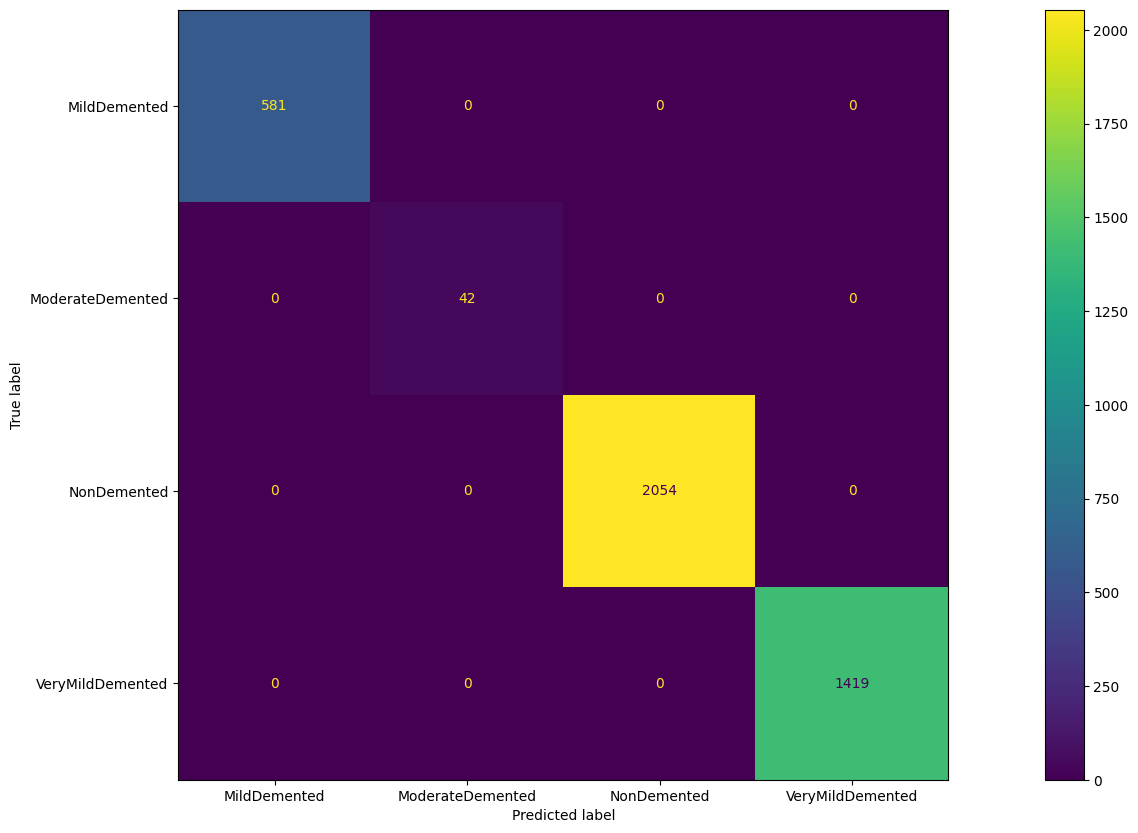

In [38]:
def visualize_model_prediction_result(classes, pred, labels, ax):
  classification_report_result = classification_report(
    labels,
    pred,
  )

  print(classification_report_result)

  fpr, tpr, thresholds = roc_curve(labels, pred, pos_label = 2)
  print(f"AUC Score: {metrics.auc(fpr, tpr)}")
  confusion_matrix_data = confusion_matrix(y_true = labels, y_pred = pred)

  confusion_matrix_display = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_data,
    display_labels = classes,
  )

  confusion_matrix_display.plot(ax = ax)

def save_fig(fig, base_name):
  PLOT_RESULT_FILE = f"{base_name}_{DATE}_{COMMENT}.png"
  SAVE_PATH_LOCATION = f"drive/MyDrive/Models/Metrics/{PLOT_RESULT_FILE}"
  print(f"Metrics has been saved in:\n{SAVE_PATH_LOCATION}")


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 10))
visualize_model_prediction_result(
    alzheimer_full_train_image_folders.classes,
    np.array(train_labels_array),
    np.array(train_outputs_array),
    ax
)

save_fig(fig, "Train_Confusion_Matrix")

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       137
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       506
           3       1.00      1.00      1.00       372

    accuracy                           1.00      1025
   macro avg       1.00      1.00      1.00      1025
weighted avg       1.00      1.00      1.00      1025

AUC Score: 0.2829837708576085
Metrics has been saved in:
drive/MyDrive/Models/Metrics/Val_Confusion_Matrix_2024_01_14_07_19_25_MultiConv_Dropout_Batch_Size_16_first_layer_42_second_layer_7_BatchNorm_LayerNorm_RandomHorizontalFlip_StepLR.png


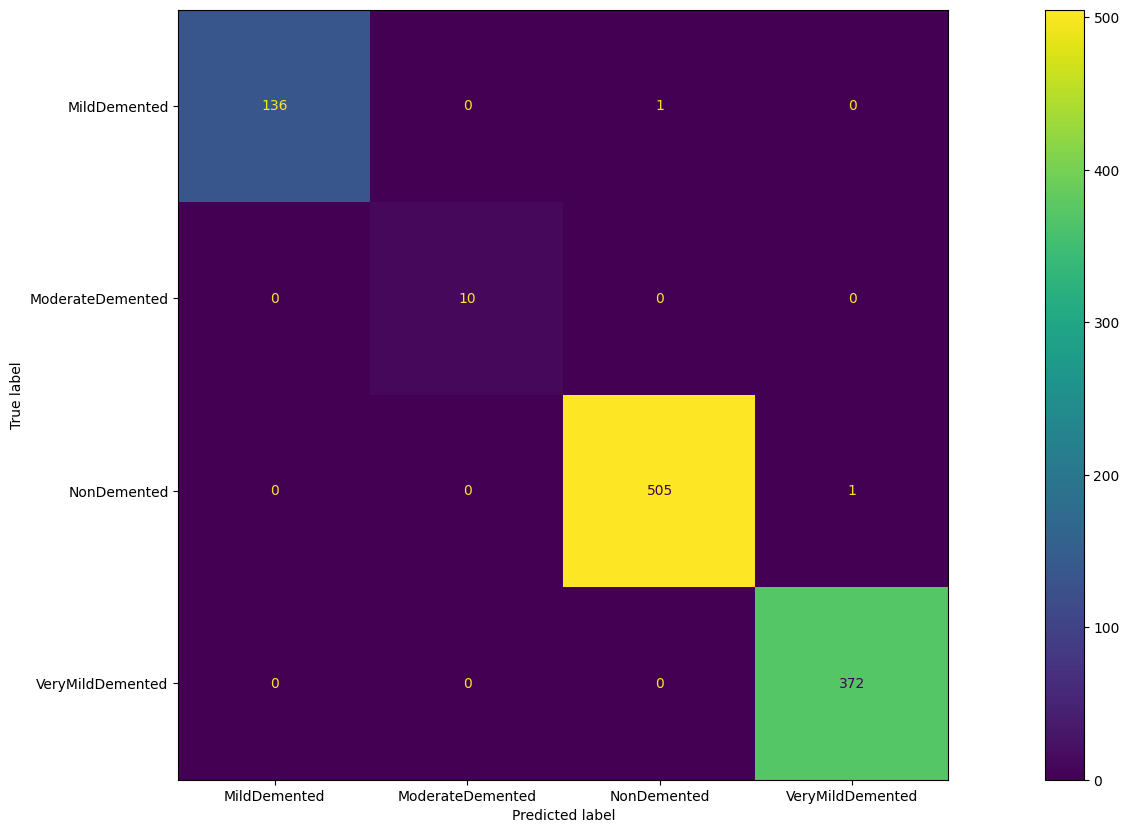

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 10))

visualize_model_prediction_result(
    alzheimer_full_train_image_folders.classes,
    np.array(val_labels_array),
    np.array(val_outputs_array),
    ax
)

save_fig(fig, "Val_Confusion_Matrix")

              precision    recall  f1-score   support

           0       0.50      0.98      0.66        92
           1       0.50      1.00      0.67         6
           2       0.87      0.85      0.86       654
           3       0.84      0.71      0.77       527

    accuracy                           0.80      1279
   macro avg       0.68      0.89      0.74      1279
weighted avg       0.83      0.80      0.81      1279

AUC Score: 0.3610507645259939
Metrics has been saved in:
drive/MyDrive/Models/Metrics/Test_Confusion_Matrix_2024_01_14_07_19_25_MultiConv_Dropout_Batch_Size_16_first_layer_42_second_layer_7_BatchNorm_LayerNorm_RandomHorizontalFlip_StepLR.png


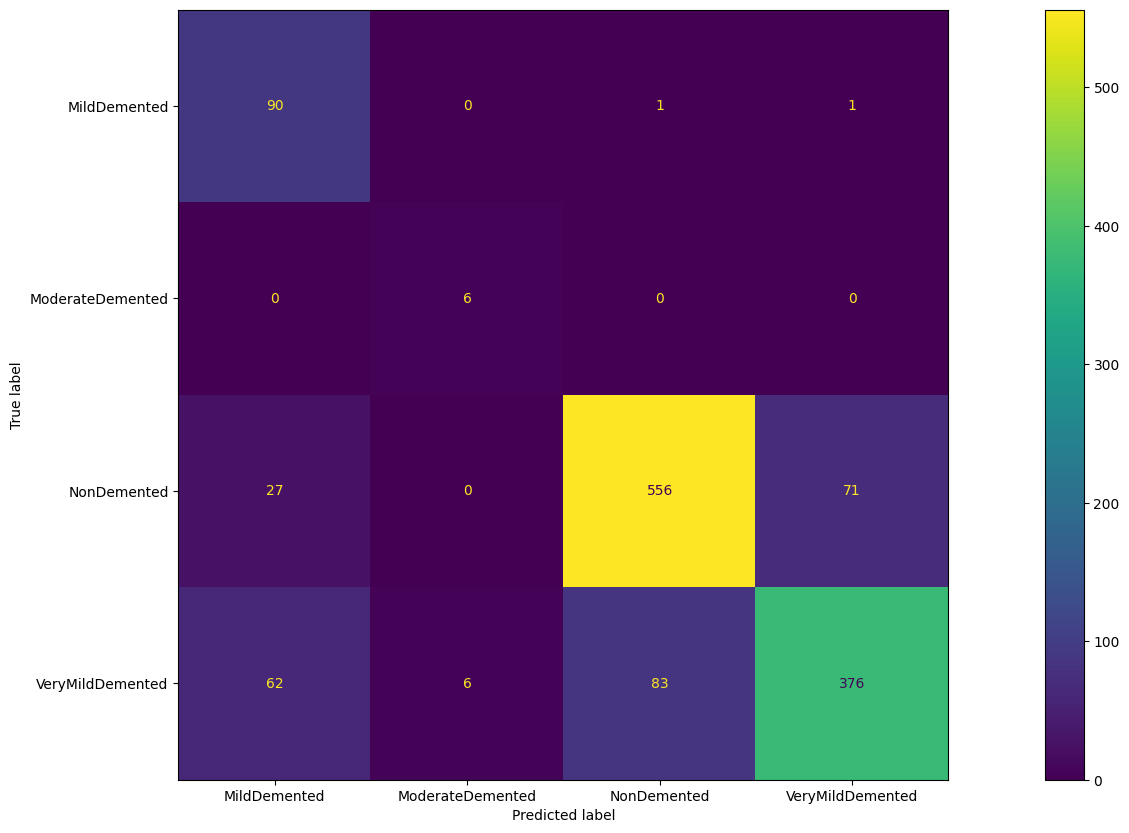

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 10))

visualize_model_prediction_result(
    alzheimer_full_train_image_folders.classes,
    np.array(test_labels_array),
    np.array(test_outputs_array),
    ax
)

save_fig(fig, "Test_Confusion_Matrix")